In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

#import lightgbm as lgb
import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

https://www.kaggle.com/dlaststark/tps-1021-la-dee-da

ver1

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 5
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-oct-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
train = train[train.columns[1:]]
test = test[test.columns[1:]]

# Preprocessing

In [6]:
features = [col for col in train.columns if 'f' in col]

In [7]:
cat_cols = train[features].columns[(train[features].nunique() < 5)]
num_cols = [col for col in test.columns if col not in cat_cols]
print(f"cat_cols: {len(cat_cols)} \nnum_cols: {len(num_cols)}")

cat_cols: 45 
num_cols: 240


In [8]:
train['mean'] = train[num_cols].mean(axis=1)
train['std'] = train[num_cols].std(axis=1)
train['min'] = train[num_cols].min(axis=1)
train['max'] = train[num_cols].max(axis=1)

test['mean'] = test[num_cols].mean(axis=1)
test['std'] = test[num_cols].std(axis=1)
test['min'] = test[num_cols].min(axis=1)
test['max'] = test[num_cols].max(axis=1)

features = features + ['mean', 'std', 'min', 'max']

In [9]:
INT8_MIN    = np.iinfo(np.int8).min
INT8_MAX    = np.iinfo(np.int8).max
INT16_MIN   = np.iinfo(np.int16).min
INT16_MAX   = np.iinfo(np.int16).max
INT32_MIN   = np.iinfo(np.int32).min
INT32_MAX   = np.iinfo(np.int32).max

FLOAT16_MIN = np.finfo(np.float16).min
FLOAT16_MAX = np.finfo(np.float16).max
FLOAT32_MIN = np.finfo(np.float32).min
FLOAT32_MAX = np.finfo(np.float32).max


def memory_usage(data, detail=1):
    if detail:
        display(data.memory_usage())
    memory = data.memory_usage().sum() / (1024*1024)
    print("Memory usage : {0:.2f}MB".format(memory))
    return memory


def compress_dataset(data):
    memory_before_compress = memory_usage(data, 0)
    print()
    length_interval      = 50
    length_float_decimal = 4

    print('='*length_interval)
    for col in data.columns:
        col_dtype = data[col][:100].dtype

        if col_dtype != 'object':
            print("Name: {0:24s} Type: {1}".format(col, col_dtype))
            col_series = data[col]
            col_min = col_series.min()
            col_max = col_series.max()

            if col_dtype == 'float64':
                print(" variable min: {0:15s} max: {1:15s}".format(str(np.round(col_min, length_float_decimal)), str(np.round(col_max, length_float_decimal))))
                if (col_min > FLOAT16_MIN) and (col_max < FLOAT16_MAX):
                    data[col] = data[col].astype(np.float32)
                    print("  float32 min: {0:15s} max: {1:15s}".format(str(FLOAT16_MIN), str(FLOAT16_MAX)))
                    print("compress float64 --> float32")
                elif (col_min > FLOAT32_MIN) and (col_max < FLOAT32_MAX):
                    data[col] = data[col].astype(np.float32)
                    print("  float32 min: {0:15s} max: {1:15s}".format(str(FLOAT32_MIN), str(FLOAT32_MAX)))
                    print("compress float64 --> float32")
                else:
                    pass
                memory_after_compress = memory_usage(data, 0)
                print("Compress Rate: [{0:.2%}]".format((memory_before_compress-memory_after_compress) / memory_before_compress))
                print('='*length_interval)

            if col_dtype == 'int64':
                print(" variable min: {0:15s} max: {1:15s}".format(str(col_min), str(col_max)))
                type_flag = 64
                if (col_min > INT8_MIN/2) and (col_max < INT8_MAX/2):
                    type_flag = 8
                    data[col] = data[col].astype(np.int8)
                    print("     int8 min: {0:15s} max: {1:15s}".format(str(INT8_MIN), str(INT8_MAX)))
                elif (col_min > INT16_MIN) and (col_max < INT16_MAX):
                    type_flag = 16
                    data[col] = data[col].astype(np.int16)
                    print("    int16 min: {0:15s} max: {1:15s}".format(str(INT16_MIN), str(INT16_MAX)))
                elif (col_min > INT32_MIN) and (col_max < INT32_MAX):
                    type_flag = 32
                    data[col] = data[col].astype(np.int32)
                    print("    int32 min: {0:15s} max: {1:15s}".format(str(INT32_MIN), str(INT32_MAX)))
                    type_flag = 1
                else:
                    pass
                memory_after_compress = memory_usage(data, 0)
                print("Compress Rate: [{0:.2%}]".format((memory_before_compress-memory_after_compress) / memory_before_compress))
                if type_flag == 32:
                    print("compress (int64) ==> (int32)")
                elif type_flag == 16:
                    print("compress (int64) ==> (int16)")
                else:
                    print("compress (int64) ==> (int8)")
                print('='*length_interval)

    print()
    memory_after_compress = memory_usage(data, 0)
    print("Compress Rate: [{0:.2%}]".format((memory_before_compress-memory_after_compress) / memory_before_compress))
    
    return data

In [10]:
train = compress_dataset(train)
test = compress_dataset(test)

Memory usage : 2212.52MB

Name: f0                       Type: float64
 variable min: 0.0418          max: 1.0            
  float32 min: -65500.0        max: 65500.0        
compress float64 --> float32
Memory usage : 2208.71MB
Compress Rate: [0.17%]
Name: f1                       Type: float64
 variable min: 0.022           max: 0.959          
  float32 min: -65500.0        max: 65500.0        
compress float64 --> float32
Memory usage : 2204.90MB
Compress Rate: [0.34%]
Name: f2                       Type: float64
 variable min: 0.0004          max: 0.9948         
  float32 min: -65500.0        max: 65500.0        
compress float64 --> float32
Memory usage : 2201.08MB
Compress Rate: [0.52%]
Name: f3                       Type: float64
 variable min: 0.0             max: 0.9798         
  float32 min: -65500.0        max: 65500.0        
compress float64 --> float32
Memory usage : 2197.27MB
Compress Rate: [0.69%]
Name: f4                       Type: float64
 variable min: 0.0       

In [11]:
test[features]

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f279,f280,f281,f282,f283,f284,mean,std,min,max
0,0.178216,0.435617,0.010230,0.202074,0.390170,0.324221,0.221722,0.738894,0.582588,0.343770,...,0,0,1,1,1,0,0.225580,0.211494,0.001878,0.997720
1,0.181250,0.476455,0.022413,0.283146,0.598020,0.349508,0.283467,0.721575,0.268990,0.208373,...,0,0,0,0,0,0,0.232219,0.212360,0.002733,0.993997
2,0.159721,0.451202,0.259649,0.365274,0.594634,0.413502,0.249318,0.642339,0.411104,0.246891,...,0,0,1,0,0,0,0.226664,0.211283,0.001809,0.995826
3,0.182424,0.520976,0.095344,0.327742,0.741830,0.358711,0.270077,0.601662,0.297742,0.252829,...,0,1,1,0,0,0,0.242564,0.217585,0.003166,0.990611
4,0.229329,0.336513,0.023511,0.300913,0.668738,0.481586,0.545660,0.667849,0.546045,0.202731,...,1,0,0,1,0,0,0.229518,0.213377,0.002766,0.991638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.185473,0.525338,0.014945,0.204029,0.498957,0.431933,0.470553,0.731268,0.452134,0.211206,...,0,0,1,0,0,0,0.236158,0.217146,0.003512,0.987847
499996,0.183194,0.553266,0.008055,0.280651,0.636591,0.478092,0.450386,0.582647,0.517270,0.225116,...,0,0,0,1,0,0,0.226063,0.209238,0.002218,0.994174
499997,0.184650,0.533643,0.011218,0.201262,0.720698,0.472888,0.427469,0.589259,0.243879,0.413022,...,0,0,0,0,0,0,0.228789,0.205474,0.003893,0.993048
499998,0.227731,0.513247,0.178603,0.313778,0.665656,0.401365,0.183369,0.708233,0.575135,0.152771,...,0,0,1,0,0,0,0.230167,0.205420,0.002671,0.995476


In [12]:
train[target]

0         1
1         1
2         1
3         1
4         1
         ..
999995    1
999996    0
999997    0
999998    1
999999    0
Name: target, Length: 1000000, dtype: int8

In [13]:
del num_cols
del cat_cols

gc.collect()

40

# XGB

In [14]:
xgb_params = {
        'objective': 'binary:logistic',
        'n_estimators':N_ESTIMATORS,
        'importance_type': 'total_gain',
        #'booster': 'gbtree',
        'n_jobs' : -1,
        'tree_method': 'hist',

        'use_label_encoder': False,
        'max_depth': 3,
        'subsample': 0.5,
        'colsample_bytree': 0.5,
        'learning_rate': 0.01187,
}

In [15]:
xgb_oof = np.zeros(train.shape[0])
xgb_pred = np.zeros(test.shape[0])
xgb_importances = pd.DataFrame()

X_test = test[features]
del test
gc.collect()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED+4]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")
    if fold <12:
        
        X_train = train[features].iloc[trn_idx]
        y_train = train[target].iloc[trn_idx]
        X_valid = train[features].iloc[val_idx]
        y_valid = train[target].iloc[val_idx]
        


        start = time.time()
        for inseed in seed_list:
            xgb_params['random_state'] = inseed

            pre_model = xgb.XGBClassifier(**xgb_params)
            pre_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_valid, y_valid)],
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                eval_metric='auc',
                verbose=VERBOSE,
            )

            xgb_params2 = xgb_params.copy()
            xgb_params2['reg_lambda'] = 0.9
            #xgb_params2['reg_alpha'] *= 0.9
            xgb_params2['learning_rate'] *= 0.1
            model = xgb.XGBClassifier(**xgb_params2)
            model.fit(
                    X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                    eval_metric='auc',
                    verbose=VERBOSE,
                    xgb_model=pre_model
            )    

            with open(f"xgb_model{fold}_seed{inseed}.pkl", 'wb') as f:
                pickle.dump(model, f)

            fi_tmp = pd.DataFrame()
            fi_tmp['feature'] = X_train.columns
            fi_tmp['importance'] = model.feature_importances_
            fi_tmp['fold'] = fold
            fi_tmp['seed'] = inseed
            xgb_importances = xgb_importances.append(fi_tmp)
            
            xgb_oof[val_idx] += model.predict_proba(X_valid, iteration_range=(0, model.best_iteration))[:,-1] / len(seed_list)
            xgb_pred += model.predict_proba(X_test, iteration_range=(0, model.best_iteration))[:,-1] / len(seed_list)
            
            del pre_model
            del model
            gc.collect()


        elapsed = time.time() - start
        auc = roc_auc_score(y_valid, xgb_oof[val_idx])
        print(f"fold {fold} - xgb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")
        
        del X_train
        del y_train
        del X_valid
        del y_valid
        gc.collect()


del X_test
gc.collect()

xgb_pred /= N_SPLITS
print(f"oof xgb_auc = {roc_auc_score(train[target], xgb_oof)}")

np.save("xgb_oof.npy", xgb_oof)
np.save("xgb_pred.npy", xgb_pred)

===== fold 0 =====
[0]	validation_0-auc:0.58451
[1000]	validation_0-auc:0.84457
[2000]	validation_0-auc:0.85051
[3000]	validation_0-auc:0.85303
[4000]	validation_0-auc:0.85436
[5000]	validation_0-auc:0.85519
[6000]	validation_0-auc:0.85564
[7000]	validation_0-auc:0.85590
[8000]	validation_0-auc:0.85606
[9000]	validation_0-auc:0.85614
[10000]	validation_0-auc:0.85618
[10218]	validation_0-auc:0.85618
[0]	validation_0-auc:0.85618
[481]	validation_0-auc:0.85618
fold 0 - xgb auc: 0.856340, elapsed time: 5330.75sec

===== fold 1 =====
[0]	validation_0-auc:0.58414
[1000]	validation_0-auc:0.84595
[2000]	validation_0-auc:0.85182
[3000]	validation_0-auc:0.85431
[4000]	validation_0-auc:0.85562
[5000]	validation_0-auc:0.85638
[6000]	validation_0-auc:0.85684
[7000]	validation_0-auc:0.85712
[8000]	validation_0-auc:0.85728
[9000]	validation_0-auc:0.85735
[9913]	validation_0-auc:0.85738
[0]	validation_0-auc:0.85738
[321]	validation_0-auc:0.85738
fold 1 - xgb auc: 0.857493, elapsed time: 5168.06sec

==

# OOF predictions

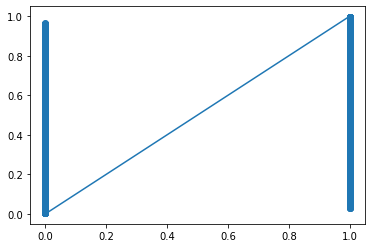

In [16]:
plt.plot(train[target], train[target])
plt.scatter(train[target], xgb_oof)

In [17]:
del train
del xgb_oof
gc.collect()

20

# Features importances

Text(0.5, 1.0, 'XGB feature importances')

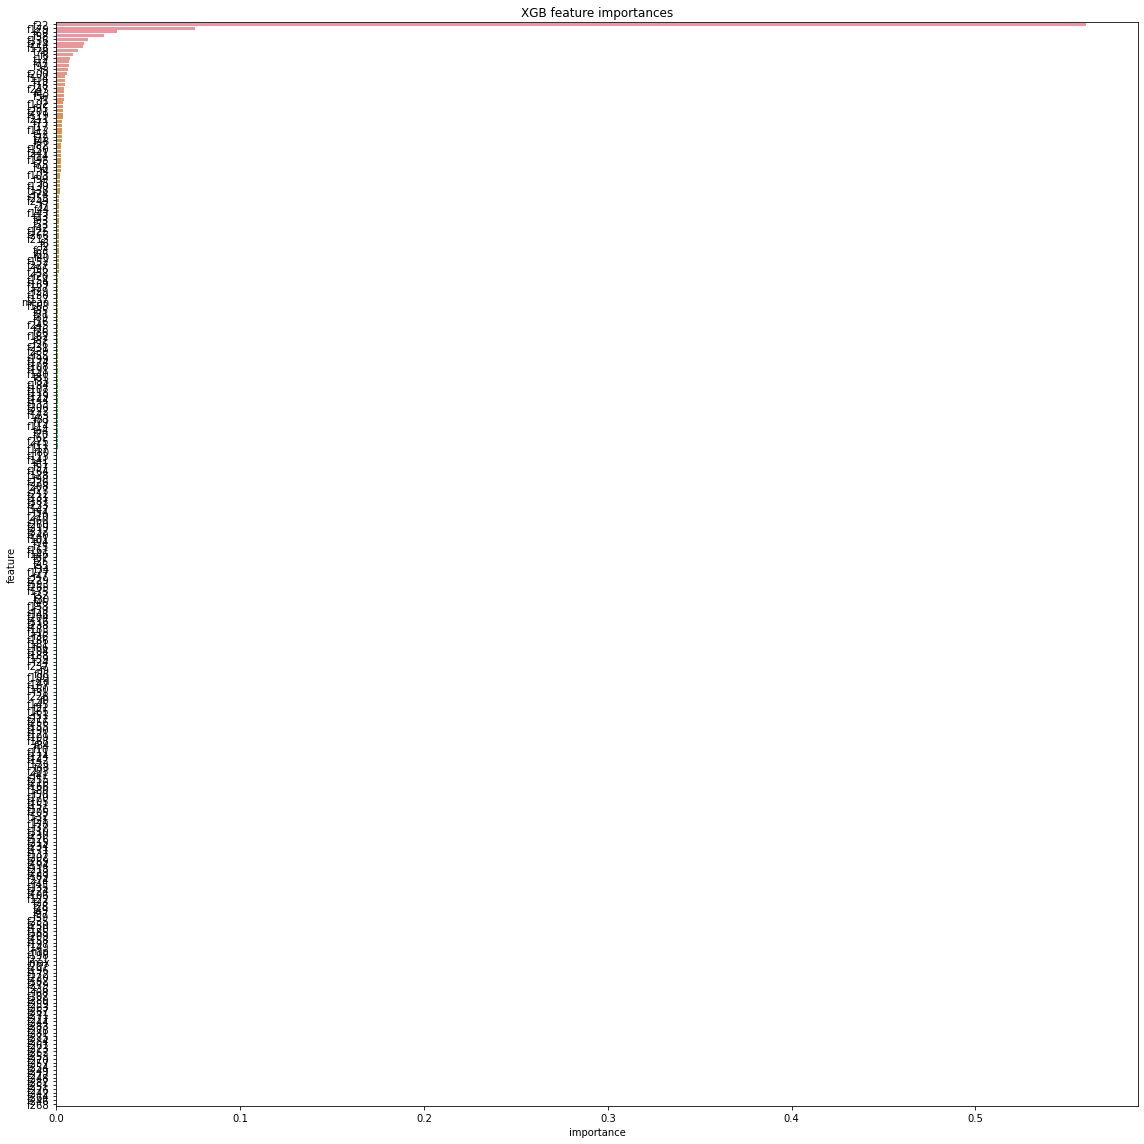

In [18]:
order = list(xgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=xgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("XGB feature importances")

# Submission

In [19]:
submission[target] = xgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,1000000,0.741429
1,1000001,0.249667
2,1000002,0.903331
3,1000003,0.842180
4,1000004,0.270996
...,...,...
499995,1499995,0.963367
499996,1499996,0.827527
499997,1499997,0.296013
499998,1499998,0.486027


# Log

seeds

2017 ver9
2018 ver10
2019 ver11
2020 ver12
2021 ver13
